In [45]:
#covid19_cleaned_8_10.csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Leave One out cross valdation 
import matplotlib.pyplot as plt
import sklearn

from sklearn.model_selection import cross_val_score

# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [57]:
DF=pd.read_csv("covid19_cleaned_8_10.csv",low_memory = False)

In [58]:
DF.columns

Index(['Unnamed: 0', 'ID', 'age', 'sex', 'city', 'province', 'country',
       'latitude', 'longitude', 'date_onset_symptoms',
       'date_admission_hospital', 'date_confirmation', 'symptoms',
       'travel_history_dates', 'travel_history_location',
       'reported_market_exposure', 'chronic_disease_binary', 'chronic_disease',
       'outcome', 'date_death_or_discharge', 'admin3', 'admin2', 'admin1',
       'travel_history_binary', 'hospitalized', 'deceased', 'fever', 'cough',
       'fatigue', 'headache', 'dizziness', 'sore throat', 'pneumonia',
       'respiratory', 'nausea', 'diarrhea', 'severe_r'],
      dtype='object')

In [59]:
df_trimmed = DF
df_trimmed["sex"] = DF['sex'].apply(lambda x: 0 if x =='female' else 1)

# Select just the columns we will train and test on
df_trimmed = DF.loc[:, [
        "sex",
        "deceased",
        "hospitalized",
        "fever",
        "cough",
        "fatigue",
        "respiratory",
        "headache",
        "dizziness",
        "pneumonia",
        "nausea",
        "diarrhea",
        "severe_r" 
        ]
]

df_trimmed = df_trimmed.dropna()


In [60]:
len(df_trimmed)

2023

In [74]:
# We will train, test, and evaluate many different models
# Define a function that performs a single train test split on a model
# to avoid repeated code.
def tts(model, x, y):
    xtrain, xtest, ytrain, ytest = train_test_split(x, y)
    model.fit(xtrain, ytrain)
    yp = model.predict(xtest)
    probs = model.predict_proba(xtest)
    acc = accuracy_score(ytest,yp)
    return ytest, probs, acc

In [75]:
# Simple ROC curve on two features.
# predict y from x.
def rocFromCol(model, x, y, label):
    ytest, prob, acc = tts(model, x, y)
    fpr, tpr, thresh = roc_curve(ytest, prob[:,1])
    plt.plot(fpr, tpr, c=np.random.rand(3,), label=label)
    plt.plot([0,1],[0,1],c="k",ls="--")
    plt.gcf().set_size_inches(6,6) 
    plt.xlabel("False Positive Rate",fontsize=14)
    plt.ylabel("True Positive Rate",fontsize=14)
    plt.grid()
    plt.legend()
    return plt.gcf()

## Predicting Deaths from Symptoms Using KNN

In [134]:
X = df_trimmed.drop("deceased", axis=1)

In [106]:
Y=np.array(df_trimmed["deceased"]) # my target using almost all features 
np.unique(Y,return_counts=True) # So there is 1158473 zeros and ..

(array([0, 1]), array([1886,  137]))

In [107]:
X["sex"].value_counts()

1    1116
0     907
Name: sex, dtype: int64

In [126]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, 
                                                        shuffle=True, stratify=Y)
# Instantiate the model
kn = KNeighborsClassifier(n_neighbors=45)  
# Train the model
kn.fit(X_train, y_train)
# Predict the model
y_pred = kn.predict(X_test)
y_scores = kn.predict_proba(X_test) 
acc_score = accuracy_score(y_test, y_pred)
print(acc_score)

0.9333333333333333


In [127]:
knn_death_scores = cross_val_score(kn, X, Y, scoring="accuracy")

In [128]:
knn_death_scores

array([0.93333333, 0.9308642 , 0.9308642 , 0.93316832, 0.87871287])

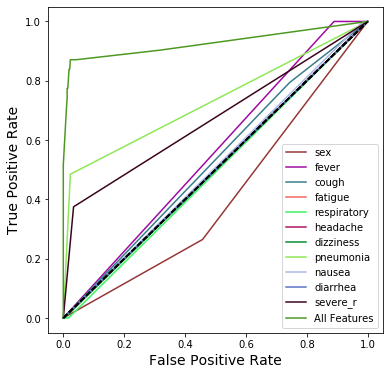

In [136]:
figs = []
predictorLabels = [
    "sex",
    "fever",
    "cough",
    "fatigue",
    "respiratory",
    "headache",
    "dizziness",
    "pneumonia",
    "nausea",
    "diarrhea",
    "severe_r" 
]

for label in predictorLabels:
    if label != "deceased":
        x = df_trimmed[label].values.reshape(-1,1)
        y = df_trimmed["deceased"].values
        figs.append(rocFromCol(kn, x, y, label))
        
figs.append(rocFromCol(kn, X, Y, "All Features"))

plt.show()

# Predicting Hospitalizations from Symptoms

In [93]:
X = df_trimmed.drop("hospitalized", axis=1)
Y = np.array(df_trimmed["hospitalized"]) # my target using almost all features 

In [138]:

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, 
                                                        shuffle=True, stratify=Y)
kn = KNeighborsClassifier(n_neighbors=45)  
kn.fit(X_train, y_train)

np.unique(Y,return_counts=True) # So there is 1158473 zeros and ..
y_pred = kn.predict(X_test)
y_scores = kn.predict_proba(X_test)
acc_score = accuracy_score(y_test, y_pred)
print(acc_score)

0.9629629629629629


In [139]:
knn_hospitalization_scores = cross_val_score(kn, X, Y, scoring="accuracy")

In [140]:
knn_hospitalization_scores

array([0.9308642 , 0.94320988, 0.99753086, 0.99009901, 0.97524752])

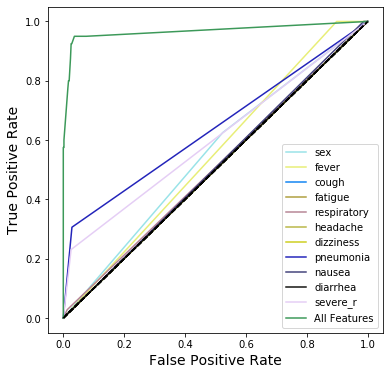

In [141]:
figs = []
predictorLabels = [
    "sex",
    "fever",
    "cough",
    "fatigue",
    "respiratory",
    "headache",
    "dizziness",
    "pneumonia",
    "nausea",
    "diarrhea",
    "severe_r" 
]

for label in predictorLabels:
    if label != "hospitalized":
        x = df_trimmed[label].values.reshape(-1,1)
        y = df_trimmed["hospitalized"].values
        figs.append(rocFromCol(kn, x, y, label))


figs.append(rocFromCol(kn, X, Y, "All Features"))

plt.show()